<a href="https://colab.research.google.com/github/nikxlvii/pytorch/blob/main/breast_cancer_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch.autograd import Variable

In [3]:
data = load_breast_cancer()
X = data['data']
y = data['target']

In [4]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.3,random_state = 24)
X_val,X_test,y_val,y_test = train_test_split(X_val,y_val,test_size=0.5,random_state = 24)

In [5]:
X_train = Variable(torch.from_numpy(X_train))
X_val = Variable(torch.from_numpy(X_val))
y_train = Variable(torch.from_numpy(y_train))
y_val = Variable(torch.from_numpy(y_val))
X_test = Variable(torch.from_numpy(X_test))
y_test = Variable(torch.from_numpy(y_test))

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(30,20)
    self.fc2 = nn.Linear(20,10)
    self.fc3 = nn.Linear(10,5)
    self.fc4 = nn.Linear(5,1)
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.sigmoid(self.fc4(x))

    return x

In [7]:
net = Net()

In [8]:
import torch.optim as optim

criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [9]:
# training loop

num_epochs = 300

for epoch in range(num_epochs):
  running_loss = 0.0
  y_pred = net(X_train.float())
  loss = criterion(y_pred, y_train.view(-1, 1).float())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  running_loss += loss.item()


print('Finished Training')

Finished Training


In [10]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

y_pred_val = net(X_val.float())
y_pred_val_binary = (y_pred_val >= 0.5).float()

precision, recall, f1, _ = precision_recall_fscore_support(y_val.view(-1, 1).numpy(), y_pred_val_binary.detach().numpy(), average='binary')

print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')

print('\nClassification Report:')
print(classification_report(y_val.view(-1, 1).numpy(), y_pred_val_binary.detach().numpy()))


Precision: 0.942
Recall: 0.942
F1 Score: 0.942

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        33
           1       0.94      0.94      0.94        52

    accuracy                           0.93        85
   macro avg       0.93      0.93      0.93        85
weighted avg       0.93      0.93      0.93        85



In [11]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=b28c792f67ec8bf8763bb56eaa8f041a82c4f2cfeb41384e043dca38a7b82369
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [12]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.numpy(),feature_names=data.feature_names,class_names=data.target_names,discretize_continuous = True)

In [13]:
# we will take two test cases, one benign and the other malignant

benign_idx = np.where(y_test.numpy() == 1)[0][0]
malignant_idx = np.where(y_test.numpy() == 0)[0][0]

In [14]:
def prob(data):
  return net.forward(Variable(torch.from_numpy(data)).float()).detach().numpy().reshape(-1,1)

In [15]:
import matplotlib.pyplot as plt

def lime_exp_as_pyplot(exp,label = 0, figsize=(8,5)):
  exp_list = exp.as_list(label = label)
  fig, ax = plt.subplots(figsize = figsize)
  vals = [x[1] for x in exp_list]
  names = [x[0] for x in exp_list]
  vals.reverse()
  names.reverse()
  colors = ['green' if x > 0 else 'red' for x in vals]
  pos = np.arange(len(exp_list)) + .5
  ax.barh(pos,vals,align='center',color = colors)
  plt.yticks(pos,names)
  return fig,ax

/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


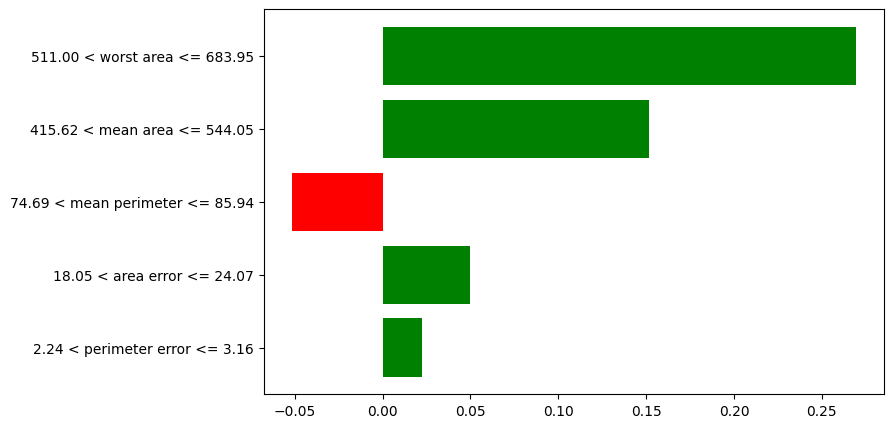

In [17]:
# interpreting the first benign case

bc1_lime = explainer.explain_instance(X_test.numpy()[benign_idx],prob,num_features = 5, top_labels = 1)
f, ax = lime_exp_as_pyplot(bc1_lime)

/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


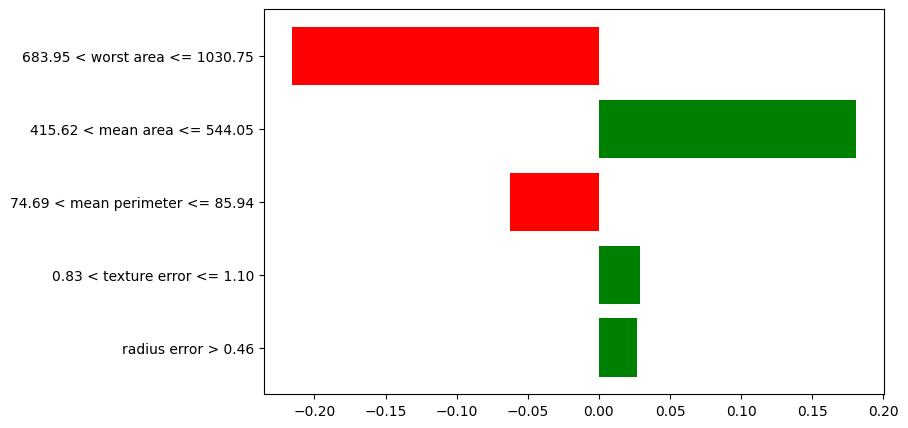

In [18]:
mc1_lime = explainer.explain_instance(X_test.numpy()[malignant_idx],prob,num_features=5,top_labels=1)

f,ax = lime_exp_as_pyplot(mc1_lime)

/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


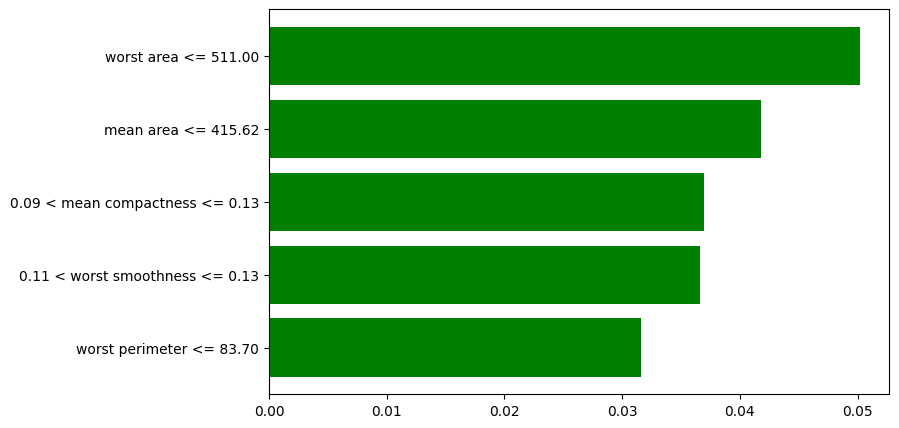

In [19]:
# changing kernel width

benign_idx2 = np.where(y_test.numpy() == 1)[0][1]

explainer_kw1 = lime.lime_tabular.LimeTabularExplainer(X_train.numpy(), feature_names=data.feature_names,class_names=data.target_names,kernel_width=1,discretize_continuous=True)

bc2_lime = explainer_kw1.explain_instance(X_test.numpy()[benign_idx2],prob,num_features = 5, top_labels = 1)
f, ax = lime_exp_as_pyplot(bc2_lime)